# [CSC8101] Engineering for AI - 2024 Spark Coursework
## Elsun Nabatov

## Coursework overview

### Inputs

- **NYC Taxi Trips dataset** - list of recorded taxi trips, each with several characteristics, namely: distance, number of passengers, origin zone, destination zone and trip cost (total amount charged to customer).
- **NYC Zones dataset** - list of zones wherein trips can originate/terminate.

### Tasks

1. Data cleaning
  1. Remove "0 distance" and 'no passengers' records.
  2. Remove outlier records. 
2. Add new columns
  1. Join with zones dataset
  2. Compute the unit profitability of each trip
3. Zone summarisation and ranking
  1. Summarise trip data per zone
  2. Obtain the top 10 ranks according to:
    1. The total trip volume
    2. Their average profitabilitiy
    3. The total passenger volume
4. Record the total and task-specific execution times for each dataset size and format.

### How to

###### Code structure and implementation

- You must implement your solution to each task in the provided function code skeleton.
- The task-specific functions are combined together to form the full pipeline code, executed last (do not modify this code).
- Before implementing the specified function skeleton, you should develop and test your solution on separate code cells (create and destroy cells as needed).

###### Development

- Develop an initial working solution for the 'S' dataset and only then optimise it for larger dataset sizes.
- To perform vectorised operations on a DataFrame:
  - use the API docs to look for existing vectorised functions in: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/functions.html
  - actions to get around the lazy execution of spark: 
  https://spark.apache.org/docs/latest/rdd-programming-guide.html#actions
  - if a customised function is required (e.g. to add a new column based on a linear combination of other columns), implement your own User Defined Function (UDF). See:  https://spark.apache.org/docs/latest/sql-ref-functions-udf-scalar.html
- Use only the `pyspark.sql` API - documentation link below - (note that searching through the docs returns results from the `pyspark.sql` API together with the `pyspark.pandas` API):
  - https://spark.apache.org/docs/3.2.0/api/python/reference/pyspark.sql.html
- Periodically download your notebook to your computer as backup and safety measure against accidental file deletion.
 
###### Execution time measurement

- Execution time is calculated and returned by the Spark Engine and shown in the output region of the cell.
- To measure the execution time of a task you must perform a `collect` or similar operation (e.g. `take`) on the returned DataFrame.

## Task 0 - Read data

The code below is ready to run. **Do not modify this code**. It does the following:

- Reads the 'zones' dataset into variable 'zone_names'
- Defines the `init_trips` function that allows you to read the 'trips' dataset (from the DBFS FileStore) given the dataset size ('S' to 'XXL') and format ('parquet' or 'delta') as function arguments
- Defines the `pipeline` function, called in Task 4 to measure the execution time of the entire data processing pipeline
- Shows you how to call the `init_trips` function and display dataset characteristics (number of rows, schema)

In [0]:
## global imports
import pyspark.sql as ps
import pyspark.sql.functions as pf
import pandas as pd

# Load zone names dataset - (much faster to read small file from git than dbfs)
zones_file_url = 'https://raw.githubusercontent.com/mutazb999/CSC8101-lab-and-coursework/main/02-assignment-spark/taxi_zone_names.csv'
zone_names = spark.createDataFrame(pd.read_csv(zones_file_url))

# Function to load trips dataset by selected dataset size
def init_trips(size = 'S', data_format = "parquet", taxi_folder = "/FileStore/tables/taxi"):     
    
    files = {
        'S'  : ['2021_07'],
        'M'  : ['2021'],
        'L'  : ['2020_21'],
        'XL' : ['1_6_2019', '7_12_2019'],
        'XXL': ['1_6_2019', '7_12_2019', '2020_21']
    }
    
    # validate input dataset size
    if size not in files.keys():
        print("Invalid input dataset size. Must be one of {}".format(list(files.keys())))
        return None               
    
    if data_format == "parquet":
        filenames = list(map(lambda s: f'{taxi_folder}/parquet/tripdata_{s}.parquet', files[size]))
        trips_df = spark.read.parquet(filenames[0])
        
        for name in filenames[1:]:
            trips_df = trips_df.union(spark.read.parquet(name))
            
    elif data_format == "delta":
        filenames = f"{taxi_folder}/delta/taxi-{size}-delta/"
        trips_df = spark.read.format("delta").load(filenames)
    
    else:
        print("Invalid data format. Must be one of {}".format(['parquet', 'delta']))
        return None
        
    print(
    """
    Trips dataset loaded!
    ---
      Size: {s}
      Format: {f}
      Tables loaded: {ds}
      Number of trips (dataset rows): {tc:,}
    """.format(s = size, f = data_format, ds = filenames, tc = trips_df.count()))
    
    return trips_df

# helper function to print dataset row count
def print_count(df):
    print("Row count: {t:,}".format(t = df.count()))

def pipeline(trips_df, with_task_12 = False, zones_df = zone_names):
    # Do not edit
    #---

    ## Task 1.1
    _trips_11 = t11_remove_zeros(trips_df)

    ## Task 1.2
    if with_task_12:
        _trips_12 = t12_remove_outliers(_trips_11)
    else:
        _trips_12 = _trips_11

    ## Task 2.1
    _trips_21 = t21_join_zones(_trips_12, zones_df = zone_names)

    ## Task 2.2
    _trips_22 = t22_calc_profit(_trips_21)

    ## Task 3.1
    _graph = t31_summarise_trips(_trips_22)

    ## Task 3.2
    _zones = t32_summarise_zones_pairs(_graph)

    _top10_trips     = t32_top10_trips(_zones)
    _top10_profit    = t32_top10_profit(_zones)
    _top10_passenger = t32_top10_passenger(_zones)
    
    return([_top10_trips, _top10_profit, _top10_passenger])

In [0]:
# CHANGE the value of argument 'size' to record the pipeline execution times for increasing dataset sizes
SIZE = 'S'
DATA_FORMAT = 'parquet'

# Load trips dataset
trips = init_trips(SIZE, DATA_FORMAT)


    Trips dataset loaded!
    ---
      Size: S
      Format: parquet
      Tables loaded: ['/FileStore/tables/taxi/parquet/tripdata_2021_07.parquet']
      Number of trips (dataset rows): 2,898,033
    


In [0]:
trips.take(1)

[Row(index=0, VendorID=1.0, tpep_pickup_datetime='2021-07-01 00:08:51', tpep_dropoff_datetime='2021-07-01 00:13:05', passenger_count=1.0, trip_distance=0.8, RatecodeID=1.0, store_and_fwd_flag='N', PULocationID=90, DOLocationID=68, payment_type=1.0, fare_amount=5.0, extra=3.0, mta_tax=0.5, tip_amount=0.0, tolls_amount=0.0, improvement_surcharge=0.3, total_amount=8.8, congestion_surcharge=2.5, cab_type='Y', lpep_pickup_datetime=None, lpep_dropoff_datetime=None, ehail_fee=None, trip_type=None)]

In [0]:
print_count(trips)

Row count: 2,898,033


In [0]:
# dataset schemas
trips.printSchema()

root
 |-- index: long (nullable = true)
 |-- VendorID: double (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- cab_type: string (nullable = true)
 |-- lpep_pickup_datetime: string (nullable = true)
 |-- lpep_dropoff_datetime: string (nullable = true)
 |--

In [0]:
display(trips[['PULocationID', 'DOLocationID', 'trip_distance', 'passenger_count', 'total_amount']].take(5))

PULocationID,DOLocationID,trip_distance,passenger_count,total_amount
90,68,0.8,1.0,8.8
113,90,0.9,1.0,8.8
88,232,2.8,1.0,13.8
79,249,1.4,1.0,12.3
142,238,2.0,0.0,12.3


In [0]:
zone_names.printSchema()

root
 |-- LocationID: long (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



In [0]:
display(zone_names.take(5))

LocationID,Borough,Zone,service_zone
1,EWR,Newark Airport,EWR
2,Queens,Jamaica Bay,Boro Zone
3,Bronx,Allerton/Pelham Gardens,Boro Zone
4,Manhattan,Alphabet City,Yellow Zone
5,Staten Island,Arden Heights,Boro Zone


## Task 1 - Filter rows

**Input:** trips dataset

### Task 1.1 - Remove "0 distance" and 'no passengers' records

Remove dataset rows that represent invalid trips:

- Trips where `trip_distance == 0` (no distance travelled)
- Trips where `passenger_count == 0` and `total_amount == 0` (we want to retain records where `total_amount` > 0 - these may be significant as the taxi may have carried some parcel, for example)

Altogether, a record is removed if it satisfies the following conditions:

`trip_distance == 0` or `(passenger_count == 0` and `total_amount == 0)`.

**Recommended:** Select only the relevant dataset columns for this and subsequent tasks: `['PULocationID', 'DOLocationID', 'trip_distance', 'passenger_count', 'total_amount')]`

### Task 1.2 - Remove outliers using the modified z-score

Despite having removed spurious "zero passengers" trips in task 1.1, columns `total_amount` and `trip_distance` contain additional outlier values that must be identified and removed.

To identify and remove outliers, you will use the modified [z-score](https://en.wikipedia.org/wiki/Standard_score) method.
The modified z-score uses the median and [Median Absolute Deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation) (MAD), instead of the mean and standard deviation, to determine how far an observation (indexed by i) is from the mean:

$$z_i = \frac{x_i - \mathit{median}(\mathbf{x})}{\mathbf{MAD}},$$

where x represents the input vector, xi is an element of x and zi is its corresponding z-score. In turn, the MAD formula is:

$$\mathbf{MAD} = 1.483 * \mathit{median}(\big\lvert x_i - \mathit{median}(\mathbf{x})\big\rvert).$$

Observations with **high** (absolute) z-score are considered outlier observations. A score is considered **high** if its __absolute z-score__ is larger than a threshold T = 3.5:

$$\big\lvert z_i \big\rvert > 3.5.$$

where T represents the number of unit standard deviations beyond which a score is considered an outlier ([wiki](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule)).

This process is repeated twice, once for each of the columns `total_amount` and `trip_distance` (in any order).

**Important:** Use the surrogate function [`percentile_approx`](https://spark.apache.org/docs/3.2.0/api/python/reference/api/pyspark.sql.functions.percentile_approx.html?highlight=percentile#pyspark.sql.functions.percentile_approx) to estimate the median (calculating the median values for a column is expensive as it cannot be parallelised efficiently).

In [0]:
from pyspark.sql.functions import col

# Task 1.1: Remove "0 distance" and 'no passengers' records implementation
def t11_remove_zeros(df):
    # Selecting only the relevant columns first to optimize processing
    df = df.select('PULocationID', 'DOLocationID', 'trip_distance', 'passenger_count', 'total_amount')
    
    # Filter out rows based on the specified conditions
    filtered_df = df.filter(
        (df.trip_distance != 0) & ~((df.passenger_count == 0) & (df.total_amount == 0))
    )
    return filtered_df

In [0]:
# execute task 1.1
trips_11 = t11_remove_zeros(trips)

print_count(trips_11)

Row count: 2,858,164


In [0]:
# Task 1.1 showing table where there is no "0" in passenger, total amount and trip distance columns
display(trips_11.take(10))

PULocationID,DOLocationID,trip_distance,passenger_count,total_amount
90,68,0.8,1.0,8.8
113,90,0.9,1.0,8.8
88,232,2.8,1.0,13.8
79,249,1.4,1.0,12.3
142,238,2.0,0.0,12.3
114,90,1.6,1.0,12.8
90,144,1.8,1.0,13.3
114,48,2.0,1.0,14.75
48,152,5.7,1.0,22.3
234,148,1.8,1.0,14.75


In [0]:
from pyspark.sql.functions import col, lit, abs as abs_col

def calculate_mad(df, column):
    median = df.approxQuantile(column, [0.5], 0.01)[0]
    # Using abs_col for the absolute value
    mad_df = df.withColumn("deviation", abs_col(col(column) - lit(median)))
    mad = 1.483 * mad_df.approxQuantile("deviation", [0.5], 0.01)[0]
    return median, mad

def filter_outliers(df, column):
    median, mad = calculate_mad(df, column)
    # Using abs_col for the absolute value in the z-score calculation
    condition = (abs_col(col(column) - lit(median)) / lit(mad)) <= 3.5
    return df.filter(condition)

def t12_remove_outliers(df):
    # Sequentially applying the filter for outliers on both columns
    df_no_outliers = filter_outliers(df, "total_amount")
    df_no_outliers = filter_outliers(df_no_outliers, "trip_distance")
    return df_no_outliers

In [0]:
# execute task 1.2
trips_12 = t12_remove_outliers(trips_11)
print_count(trips_12)

Row count: 2,435,246


In [0]:
# Task 1.2 showing table without outliers 
display(trips_12.take(10))

PULocationID,DOLocationID,trip_distance,passenger_count,total_amount
90,68,0.8,1.0,8.8
113,90,0.9,1.0,8.8
88,232,2.8,1.0,13.8
79,249,1.4,1.0,12.3
142,238,2.0,0.0,12.3
114,90,1.6,1.0,12.8
90,144,1.8,1.0,13.3
114,48,2.0,1.0,14.75
48,152,5.7,1.0,22.3
234,148,1.8,1.0,14.75


## Task 2 - Compute new columns

### Task 2.1 - Zone names

Obtain the **start** and **end** zone names of each trip by joining the `trips` and `zone_names` datasets (i.e. by using the `zone_names` dataset as lookup table).

**Note:** The columns containing the start and end zone ids of each trip are named `PULocationID` and `DOLocationID`, respectively.

### Task 2.2 - Unit profitability

Compute the column `unit_profitability = total_amount / trip_distance`.

In [0]:
def t21_join_zones(trips_df, zones_df):
    # Rename columns in zones_df to avoid ambiguity
    pickup_zones_df = zones_df.withColumnRenamed('LocationID', 'PULocationID') \
                              .withColumnRenamed('Zone', 'PUZone') \
                              .withColumnRenamed('Borough', 'PUBorough')  # Rename Borough for pickup
    
    dropoff_zones_df = zones_df.withColumnRenamed('LocationID', 'DOLocationID') \
                               .withColumnRenamed('Zone', 'DOZone') \
                               .withColumnRenamed('Borough', 'DOBorough')  # Rename Borough for drop-off

    # Join for Pickup Location
    trips_with_pickup_zones = trips_df.join(pickup_zones_df, 'PULocationID', 'left')

    # Join for Drop-off Location
    trips_with_all_zones = trips_with_pickup_zones.join(dropoff_zones_df, 'DOLocationID', 'left')

    # Explicitly selecting the columns in the final DataFrame to avoid duplicates
    final_df = trips_with_all_zones.select(
        trips_df["*"],  # Selecting all columns from the original trips_df
        "PUZone", "PUBorough", "DOZone", "DOBorough"  # Selecting the renamed columns without duplication
    )

    return final_df

In [0]:
# execute task 2.1
trips_21 = t21_join_zones(trips_12, zones_df = zone_names)
print_count(trips_21)

Row count: 2,435,246


In [0]:
# Task 2.1 join table showing 10 example rows
display(trips_21.take(10))

PULocationID,DOLocationID,trip_distance,passenger_count,total_amount,PUZone,PUBorough,DOZone,DOBorough
90,68,0.8,1.0,8.8,Flatiron,Manhattan,East Chelsea,Manhattan
113,90,0.9,1.0,8.8,Greenwich Village North,Manhattan,Flatiron,Manhattan
88,232,2.8,1.0,13.8,Financial District South,Manhattan,Two Bridges/Seward Park,Manhattan
79,249,1.4,1.0,12.3,East Village,Manhattan,West Village,Manhattan
142,238,2.0,0.0,12.3,Lincoln Square East,Manhattan,Upper West Side North,Manhattan
114,90,1.6,1.0,12.8,Greenwich Village South,Manhattan,Flatiron,Manhattan
90,144,1.8,1.0,13.3,Flatiron,Manhattan,Little Italy/NoLiTa,Manhattan
114,48,2.0,1.0,14.75,Greenwich Village South,Manhattan,Clinton East,Manhattan
48,152,5.7,1.0,22.3,Clinton East,Manhattan,Manhattanville,Manhattan
234,148,1.8,1.0,14.75,Union Sq,Manhattan,Lower East Side,Manhattan


In [0]:
from pyspark.sql.functions import col

def t22_calc_profit(df):
    # Calculate unit profitability and add it as a new column
    df_with_profit = df.withColumn("unit_profitability", col("total_amount") / col("trip_distance"))
    return df_with_profit

In [0]:
# execute task 2.2
trips_22 = t22_calc_profit(trips_21)

print_count(trips_22)

Row count: 2,435,246


In [0]:
#Task 2.2 showing table with unit profitability column
display(trips_22.take(10))

PULocationID,DOLocationID,trip_distance,passenger_count,total_amount,PUZone,PUBorough,DOZone,DOBorough,unit_profitability
90,68,0.8,1.0,8.8,Flatiron,Manhattan,East Chelsea,Manhattan,11.0
113,90,0.9,1.0,8.8,Greenwich Village North,Manhattan,Flatiron,Manhattan,9.777777777777779
88,232,2.8,1.0,13.8,Financial District South,Manhattan,Two Bridges/Seward Park,Manhattan,4.928571428571429
79,249,1.4,1.0,12.3,East Village,Manhattan,West Village,Manhattan,8.785714285714286
142,238,2.0,0.0,12.3,Lincoln Square East,Manhattan,Upper West Side North,Manhattan,6.15
114,90,1.6,1.0,12.8,Greenwich Village South,Manhattan,Flatiron,Manhattan,8.0
90,144,1.8,1.0,13.3,Flatiron,Manhattan,Little Italy/NoLiTa,Manhattan,7.388888888888889
114,48,2.0,1.0,14.75,Greenwich Village South,Manhattan,Clinton East,Manhattan,7.375
48,152,5.7,1.0,22.3,Clinton East,Manhattan,Manhattanville,Manhattan,3.912280701754386
234,148,1.8,1.0,14.75,Union Sq,Manhattan,Lower East Side,Manhattan,8.194444444444445


## Task 3: Rank zones by traffic, passenger volume and profitability

### 3.1 - Summarise interzonal travel

Build a graph data structure of zone-to-zone traffic, representing aggregated data about trips between any two zones. The graph will have one node for each zone and one edge connecting each pair of zones. In addition, edges contain aggregate information about all trips between those zones. 

For example, zones Z1 and Z2 are connected by *two* edges: edge Z1 --> Z2 carries aggregate data about all trips that originated in Z1 and ended in Z2, and edge Z2 --> Z1 carries aggregate data about all trips that originated in Z2 and ended in Z1.

The aggregate information of interzonal travel must include the following data:

- `average_unit_profit` - the average unit profitability (calculated as `mean(unit_profitability)`).
- `trips_count` -- the total number of recorded trips.
- `total_passengers` -- the total number of passenger across all trips (sum of `passenger_count`).

This graph can be represented as a new dataframe, with schema:

\[`PULocationID`, `DOLocationID`, `average_unit_profit`, `trips_count`, `total_passengers` \]

__hint__: the `groupby()` operator produces a `pyspark.sql.GroupedData` structure. You can then calculate multiple aggregations from this using `pyspark.sql.GroupedData.agg()`: 
- https://spark.apache.org/docs/3.2.0/api/python/reference/pyspark.pandas/api/pyspark.pandas.DataFrame.groupby.html
- https://spark.apache.org/docs/3.2.0/api/python/reference/api/pyspark.sql.GroupedData.agg.html

### Task 3.2 - Obtain top-10 zones

For each of the following measures, report the top-10 zones _using their plain names you dereferenced in the previous step, not the codes_. Note that this requires ranking the nodes in different orders. Specifically, you need to calculate the following further aggregations:

- the **total** number of trips originating from Z. This is simply the sum of `trips_count` over all outgoing edges for Z, i.e., edges of the form Z -> \*
- the **average** profitability of a zone. This is the average of all `average_unit_profit` over all *outgoing* edges from Z.
- The **total** passenger volume measured as the **sum** of `total_passengers` carried in trips that originate from Z

In [0]:
from pyspark.sql import functions as F

"""
    Summarizes trips data by constructing a graph structure where each node represents a zone, and edges represent aggregated data about trips between pairs of zones (PULocationID and DOLocationID).

    Parameters:
    DataFrame containing trips data with columns for pickup location ID (PULocationID), dropoff location ID (DOLocationID), unit profitability, and passenger count.

    Returns:
    DataFrame (aggregated_df) containing aggregated information for each pair of zones, including: average unit profitability, total number of trips, and total number of passengers.
    """

def t31_summarise_trips(df):
    # Group by PULocationID and DOLocationID to build the graph structure
    aggregated_df = df.groupBy("PULocationID", "DOLocationID").agg(
        # The average unit profitability (as 'average_unit_profit')
        F.mean("unit_profitability").alias("average_unit_profit"),
        # The total number of trips between the two zones (as 'trips_count')
        F.count("*").alias("trips_count"),
        # The total number of passengers across all trips between the two zones (as 'total_passengers')
        F.sum("passenger_count").alias("total_passengers")
    )
    
    return aggregated_df

In [0]:
# execute task 3.1
graph = t31_summarise_trips(trips_22)
print_count(graph)

Row count: 11,833


In [0]:
# showing 3.1 trip summarization table based on profit, trip and passenger
display(graph.take(10))

PULocationID,DOLocationID,average_unit_profit,trips_count,total_passengers
228,26,7.41471058428216,8,2.0
108,26,6.236111111111111,1,1.0
25,26,4.722645989088705,2,3.0
21,29,8.13479934900303,9,1.0
97,26,4.504891363110619,9,10.0
22,26,15.249447857883409,32,2.0
178,26,9.437984319433491,9,3.0
26,26,19.89301966792171,86,11.0
181,26,6.467595978916211,11,6.0
87,29,6.241486068111455,1,1.0


In [0]:
from pyspark.sql import functions as F

def t32_summarise_zones_pairs(df, zones_df):
    # Aggregate trips data by pickup location
    df = df.groupBy("PULocationID").agg(
        F.avg("average_unit_profit").alias("average_profitability"),
        F.count("*").alias("total_trips"),
        F.sum("trips_count").alias("total_passengers")
    )
    
    # Alias the zones DataFrame to avoid column ambiguity
    zones_df_alias = zones_df.alias("zones")
    
    # Join with zone_names to get zone names, using DataFrame alias to disambiguate
    df = df.join(zones_df_alias, df["PULocationID"] == zones_df_alias["LocationID"], "left")\
                   .select(
                       df["PULocationID"],
                       F.col("zones.Zone").alias("zone_name"),
                       "average_profitability",
                       "total_trips",
                       "total_passengers"
                   )
    
    return df


# Top 10 ranked zones by total trips
def t32_top10_trips(df_zones):
    return df_zones.orderBy(F.desc("total_trips")).limit(10)

# Top 10 ranked zones by average profitability
def t32_top10_profit(df_zones):
    return df_zones.orderBy(F.desc("average_profitability")).limit(10)

# Top 10 ranked zones by total passenger volume
def t32_top10_passenger(df_zones):
    return df_zones.orderBy(F.desc("total_passengers")).limit(10)

In [0]:
zones = t32_summarise_zones_pairs(graph, zone_names)

top10_trips     = t32_top10_trips(zones)
top10_profit    = t32_top10_profit(zones)
top10_passenger = t32_top10_passenger(zones)

In [0]:
# "Top 10 trips" table
display(top10_trips)

PULocationID,zone_name,average_profitability,total_trips,total_passengers
265,null,11.695315512234426,213,2707
264,NV,8.452141066876376,130,11583
79,East Village,7.7509845653763225,104,72429
141,Lenox Hill West,6.558095770959325,102,73531
107,Gramercy,7.857798853263775,99,65534
237,Upper East Side South,6.9217966736424374,98,121281
186,Penn Station/Madison Sq West,7.964996726649009,98,95864
170,Murray Hill,7.810456353197745,97,87410
234,Union Sq,7.642858650333161,97,73000
249,West Village,8.686959834448848,97,54470


In [0]:
# "Top 10 Profit" table
display(top10_profit)

PULocationID,zone_name,average_profitability,total_trips,total_passengers
15,Bay Terrace/Fort Totten,373.64352610622007,10,43
10,Baisley Park,106.87455960856855,29,307
207,Saint Michaels Cemetery/Woodside,103.12501378067475,5,25
190,Prospect Park,95.73464655984553,33,71
241,Van Cortlandt Village,59.39185912313199,42,185
101,Glen Oaks,48.41059594606823,8,20
115,Grymes Hill/Clifton,38.65,2,2
59,Crotona Park,36.84437137879828,7,7
81,Eastchester,35.018824815920645,28,139
89,Flatbush/Ditmas Park,34.99531722605364,57,634


In [0]:
# "Top 10 Passenger" table
display(top10_passenger)

PULocationID,zone_name,average_profitability,total_trips,total_passengers
237,Upper East Side South,6.9217966736424374,98,121281
236,Upper East Side North,7.10318953158156,92,102930
186,Penn Station/Madison Sq West,7.964996726649009,98,95864
161,Midtown Center,7.7010961429955795,94,92794
170,Murray Hill,7.810456353197745,97,87410
162,Midtown East,7.4610168132805095,92,84103
142,Lincoln Square East,7.580620086079359,82,80200
239,Upper West Side South,6.926375170619549,80,73739
48,Clinton East,9.000742071113594,91,73585
141,Lenox Hill West,6.558095770959325,102,73531


## Task 4 - Record the pipeline's execution time

Record the execution time of:

1. the whole pipeline
2. the whole pipeline except task 1.2

on the two tables below, for all dataset sizes: `'S'`, `'M'`, `'L'`, `'XL'`, `'XXL'`, and data formats: `parquet` and `delta`.

Analyse the resulting execution times and comment on the effect of dataset size, dataset format and task complexity (with and without task 1.2) on pipeline performance.

In [0]:
# CHANGE the value of the following arguments to record the pipeline execution times for increasing dataset sizes
SIZE = 'S'
DATA_FORMAT = 'parquet'
WITH_TASK_12 = True

# Load trips dataset
trips = init_trips(SIZE, DATA_FORMAT)


    Trips dataset loaded!
    ---
      Size: S
      Format: parquet
      Tables loaded: ['/FileStore/tables/taxi/parquet/tripdata_2021_07.parquet']
      Number of trips (dataset rows): 2,898,033
    


In [0]:
def pipeline(trips_df, with_task_12=True, zones_df=None):
    if zones_df is None:
        zones_df = zone_names

    ## Task 1.1
    _trips_11 = t11_remove_zeros(trips_df)

    ## Task 1.2
    if with_task_12:
        _trips_12 = t12_remove_outliers(_trips_11)
    else:
        _trips_12 = _trips_11

    ## Task 2.1
    _trips_21 = t21_join_zones(_trips_12, zones_df=zones_df)  # Pass zones_df as argument

    ## Task 2.2
    _trips_22 = t22_calc_profit(_trips_21)

    ## Task 3.1
    _graph = t31_summarise_trips(_trips_22)

    ## Task 3.2
    _zones = t32_summarise_zones_pairs(_graph, zones_df=zones_df)  # Corrected to pass zones_df

    _top10_trips = t32_top10_trips(_zones)
    _top10_profit = t32_top10_profit(_zones)
    _top10_passenger = t32_top10_passenger(_zones)
    
    return [_top10_trips, _top10_profit, _top10_passenger]


In [0]:
import time

dataset_sizes = ['S', 'M', 'L', 'XL', 'XXL']
data_formats = ['parquet', 'delta']
execution_results = []

for data_format in data_formats:
    for size in dataset_sizes:
        for include_task_12 in [True, False]:
            start_time = time.time()
            
            trips_df = init_trips(size, data_format)
            row_count = trips_df.count()
            
            results = pipeline(trips_df, include_task_12, zone_names)
            
            execution_time = time.time() - start_time
            
            sec_per_1M_records = execution_time / (row_count / 1_000_000)
            
            print(f"Execution Time: {execution_time:.2f} seconds\n")

            execution_results.append({
                'size': size,
                'format': data_format,
                'include_task_12': include_task_12,
                'row_count': row_count,
                'execution_time': execution_time,
                'sec_per_1M_records': sec_per_1M_records
            })

# Print execution_results for analysis
for result in execution_results:
    print(result)


    Trips dataset loaded!
    ---
      Size: S
      Format: parquet
      Tables loaded: ['/FileStore/tables/taxi/parquet/tripdata_2021_07.parquet']
      Number of trips (dataset rows): 2,898,033
    
Execution Time: 3.82 seconds


    Trips dataset loaded!
    ---
      Size: S
      Format: parquet
      Tables loaded: ['/FileStore/tables/taxi/parquet/tripdata_2021_07.parquet']
      Number of trips (dataset rows): 2,898,033
    
Execution Time: 0.56 seconds


    Trips dataset loaded!
    ---
      Size: M
      Format: parquet
      Tables loaded: ['/FileStore/tables/taxi/parquet/tripdata_2021.parquet']
      Number of trips (dataset rows): 15,571,166
    
Execution Time: 12.37 seconds


    Trips dataset loaded!
    ---
      Size: M
      Format: parquet
      Tables loaded: ['/FileStore/tables/taxi/parquet/tripdata_2021.parquet']
      Number of trips (dataset rows): 15,571,166
    
Execution Time: 0.50 seconds


    Trips dataset loaded!
    ---
      Size: L
      Format: 

In [0]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
df = pd.DataFrame(execution_results)
print(df)

   size   format  include_task_12  row_count  execution_time  \
0     S  parquet             True    2898033        3.822014   
1     S  parquet            False    2898033        0.556520   
2     M  parquet             True   15571166       12.367341   
3     M  parquet            False   15571166        0.504049   
4     L  parquet             True   41953716       26.531668   
5     L  parquet            False   41953716        0.659571   
6    XL  parquet             True   90443069       35.493002   
7    XL  parquet            False   90443069        0.757047   
8   XXL  parquet             True  132396785       35.735926   
9   XXL  parquet            False  132396785        1.588924   
10    S    delta             True    2898033        4.412906   
11    S    delta            False    2898033        0.841339   
12    M    delta             True   15571166        6.013703   
13    M    delta            False   15571166        0.569047   
14    L    delta             True   4195

In [0]:
# running and record the resulting execution time shown by databricks (on the cell footer)

# IMPORTANT: this function calls all task functions in order of occurrence. For this code to run without errors, it is loaded into memory all of the previous task-specific functions.
pipeline(trips, with_task_12 = WITH_TASK_12)

[DataFrame[PULocationID: bigint, zone_name: string, average_profitability: double, total_trips: bigint, total_passengers: bigint],
 DataFrame[PULocationID: bigint, zone_name: string, average_profitability: double, total_trips: bigint, total_passengers: bigint],
 DataFrame[PULocationID: bigint, zone_name: string, average_profitability: double, total_trips: bigint, total_passengers: bigint]]

_Table 1. Pipeline performance for `parquet` format._

| metric                      | S    | M    | L    | XL   | XXL  |
|-----------------------------|------|------|------|------|------|
| rows (M)                    | 2.90 | 15.57 | 41.95 | 90.44 | 132.40 |
| execution time (w/o 1.2)    | 0.56 | 0.50  | 0.66  | 0.76  | 1.59  |
| execution time              | 3.82 | 12.37 | 26.53 | 35.49 | 35.74 |
| sec / 1M records (w/o 1.2)  | 0.19 | 0.03  | 0.02  | 0.01  | 0.01  |
| sec / 1M records            | 1.32 | 0.79  | 0.63  | 0.39  | 0.27  |

_Table 2. Pipeline performance for `delta` format._

| metric                      | S    | M    | L    | XL   | XXL  |
|-----------------------------|------|------|------|------|------|
| rows (M)                    | 2.90 | 15.57 | 41.95 | 90.44 | 132.40 |
| execution time (w/o 1.2)    | 0.84 | 0.57  | 0.48  | 0.57  | 0.59  |
| execution time              | 4.41 | 6.01  | 7.87  | 17.86 | 18.56 |
| sec / 1M records (w/o 1.2)  | 0.29 | 0.04  | 0.01  | 0.01  | 0.00  |
| sec / 1M records            | 1.52 | 0.39  | 0.19  | 0.20  | 0.14  |


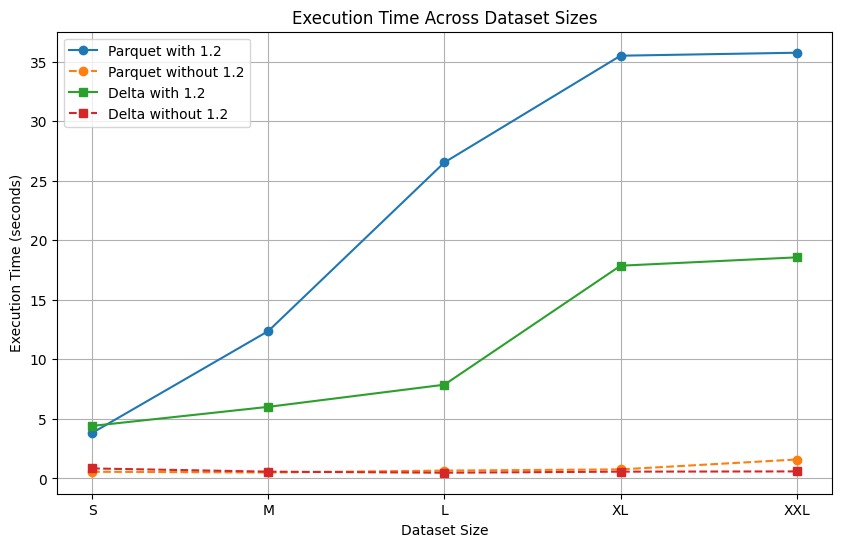

In [0]:
import matplotlib.pyplot as plt

# Dataset sizes
sizes = ['S', 'M', 'L', 'XL', 'XXL']

# Execution times for parquet (with and without task 1.2)
execution_time_parquet_with_12 = [3.82, 12.37, 26.53, 35.49, 35.74]
execution_time_parquet_without_12 = [0.56, 0.50, 0.66, 0.76, 1.59]

# Execution times for delta (with and without task 1.2)
execution_time_delta_with_12 = [4.41, 6.01, 7.87, 17.86, 18.56]
execution_time_delta_without_12 = [0.84, 0.57, 0.48, 0.57, 0.59]

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(sizes, execution_time_parquet_with_12, label='Parquet with 1.2', marker='o')
plt.plot(sizes, execution_time_parquet_without_12, label='Parquet without 1.2', marker='o', linestyle='--')
plt.plot(sizes, execution_time_delta_with_12, label='Delta with 1.2', marker='s')
plt.plot(sizes, execution_time_delta_without_12, label='Delta without 1.2', marker='s', linestyle='--')

plt.title('Execution Time Across Dataset Sizes')
plt.xlabel('Dataset Size')
plt.ylabel('Execution Time (seconds)')
plt.legend()
plt.grid(True)

plt.show()